# Part II (Model Calibration)

# PlainVanillaPricer Documentation

## Overview
`PlainVanillaPricer` is a comprehensive class for pricing and calibrating vanilla options using various models. It implements both Black-Scholes and Displaced Diffusion pricing models, along with utilities for implied volatility calculation and model calibration.

## Class Structure

### Core Pricing Models
- **Black-Scholes Model**
  - Method: `black_scholes_model(S, K, r, sigma, T)`
  - Parameters:
    - S: Spot price
    - K: Strike price
    - r: Risk-free rate
    - sigma: Volatility
    - T: Time to maturity (in years)

- **Displaced Diffusion Model**
  - Method: `displaced_diffusion_model(S, K, r, sigma, T, beta)`
  - Additional Parameter:
    - beta: Displacement parameter

### Volatility Calculation

```python
calculate_implied_volatility(S, K, r, price, T, option_type)
```
Calculates implied volatility using the Black-Scholes model and Brent's method.
- Parameters:
  - price: Market price of the option
  - option_type: "call" or "put"
- Returns: Implied volatility (float)

### Model Calibration

#### Displaced Diffusion Calibration
```python
calibrate_DD_parameters(iv_dict, spot_price, rates)
```
Calibrates the Displaced Diffusion model parameters.
- Parameters:
  - iv_dict: Dictionary of implied volatilities
  - spot_price: Current spot price
  - rates: DataFrame of risk-free rates
- Returns: Dictionary of calibrated parameters (sigma, beta) by expiry

#### SABR Model Calibration
```python
calibrate_SABR_parameters(iv_dict, spot_price, rates, fixed_beta)
```
Calibrates the SABR model parameters.
- Parameters:
  - fixed_beta: Fixed beta parameter for SABR model
- Returns: Dictionary of calibrated parameters (F, alpha, beta, rho, nu) by expiry

### Visualization
```python
plot_volatilities(ax, iv_dict, dd_params, sabr_params, spot_price, title)
```
Plots market vs model implied volatilities.
- Displays:
  - Market implied volatilities
  - Displaced Diffusion model volatilities
  - SABR model volatilities

## Usage Example

```python
# Initialize pricer
vanilla_option = PlainVanillaPricer()

# Calculate option price
bs_model = vanilla_option.black_scholes_model(S=100, K=100, r=0.05, sigma=0.2, T=1)
call_price = bs_model.calculate_call_price()

# Calculate implied volatility
implied_vol = vanilla_option.calculate_implied_volatility(
    S=100, K=100, r=0.05, price=5.0, T=1, option_type="call"
)

# Calibrate models
dd_params = vanilla_option.calibrate_DD_parameters(iv_dict, spot_price, rates)
sabr_params = vanilla_option.calibrate_SABR_parameters(iv_dict, spot_price, rates, fixed_beta=0.7)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
vanilla_option.plot_volatilities(
    ax, iv_dict, dd_params, sabr_params, spot_price, "Option Implied Volatilities"
)
```

## Dependencies
- numpy
- scipy
- pandas
- matplotlib

## Notes
- All time inputs should be in years
- Rates should be in decimal form (e.g., 0.05 for 5%)
- The SABR model implementation uses a fixed beta parameter

In [ ]:
import numpy as np
from scipy.stats import norm
from abc import ABC, abstractmethod
from scipy.optimize import brentq, least_squares
import pandas as pd
import matplotlib.pyplot as plt

class AbstractOptionModel(ABC):
    @abstractmethod
    def calculate_call_price(self) -> float:
        pass

    @abstractmethod
    def calculate_put_price(self) -> float:
        pass

class AbstractBlackScholesModel(AbstractOptionModel):
    def __init__(self, S: float, K: float, r: float, sigma: float, T: float):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()
        self.discount_factor = np.exp(-self.r * self.T)

    def _calculate_d1(self) -> float:
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (
            self.sigma * np.sqrt(self.T)
        )

    def _calculate_d2(self) -> float:
        return self.d1 - self.sigma * np.sqrt(self.T)

class AbstractDisplacedDiffusionModel(AbstractOptionModel):
    def __init__(self, S: float, K: float, r: float, sigma: float, T: float, beta: float):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.beta = beta

        self.F = S * np.exp(r * T)
        self.adjusted_F = self.F / self.beta
        self.adjusted_K = self.K + ((1 - self.beta) / self.beta) * self.F
        self.adjusted_sigma = self.sigma * self.beta
        self.discount_factor = np.exp(-self.r * self.T)

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()

    def _calculate_d1(self) -> float:
        return (
            np.log(self.adjusted_F / self.adjusted_K)
            + 0.5 * self.adjusted_sigma**2 * self.T
        ) / (self.adjusted_sigma * np.sqrt(self.T))

    def _calculate_d2(self) -> float:
        return self.d1 - self.adjusted_sigma * np.sqrt(self.T)

class VanillaBlackScholesModel(AbstractBlackScholesModel):
    def calculate_call_price(self) -> float:
        return self.S * norm.cdf(self.d1) - self.K * self.discount_factor * norm.cdf(self.d2)

    def calculate_put_price(self) -> float:
        return self.K * self.discount_factor * norm.cdf(-self.d2) - self.S * norm.cdf(-self.d1)

class VanillaDisplacedDiffusionModel(AbstractDisplacedDiffusionModel):
    def calculate_call_price(self) -> float:
        return self.discount_factor * (
            self.adjusted_F * norm.cdf(self.d1) - self.adjusted_K * norm.cdf(self.d2)
        )

    def calculate_put_price(self) -> float:
        return self.discount_factor * (
            self.adjusted_K * norm.cdf(-self.d2) - self.adjusted_F * norm.cdf(-self.d1)
        )

class LimitedVanillaOption(ABC):
    @abstractmethod
    def black_scholes_model(self) -> AbstractBlackScholesModel:
        pass

    @abstractmethod
    def displaced_diffusion_model(self) -> AbstractDisplacedDiffusionModel:
        pass

class PlainVanillaPricer(LimitedVanillaOption):
    def black_scholes_model(
        self, S: float, K: float, r: float, sigma: float, T: float
    ) -> AbstractBlackScholesModel:
        return VanillaBlackScholesModel(S, K, r, sigma, T)

    def displaced_diffusion_model(
        self, S: float, K: float, r: float, sigma: float, T: float, beta: float
    ) -> AbstractDisplacedDiffusionModel:
        return VanillaDisplacedDiffusionModel(S, K, r, sigma, T, beta)

    def calculate_implied_volatility(self, S: float, K: float, r: float, price: float, T: float, option_type: str) -> float:
        try:
            bs_model = lambda sigma: self.black_scholes_model(S, K, r, sigma, T)
            if option_type.lower() == "call":
                implied_vol = brentq(lambda sigma: price - bs_model(sigma).calculate_call_price(), 1e-12, 10.0)
            elif option_type.lower() == "put":
                implied_vol = brentq(lambda sigma: price - bs_model(sigma).calculate_put_price(), 1e-12, 10.0)
            else:
                raise ValueError("Invalid option type")
        except Exception:
            implied_vol = np.nan
        return implied_vol

    def calculate_DD_vol_error(self, beta: float, strikes: list, vols: list, S: float, r: float, sigma: float, T: float, option_types: list) -> float:
        error = 0.0
        for strike, vol, opt_type in zip(strikes, vols, option_types):
            model = self.displaced_diffusion_model(S, strike, r, sigma, T, beta)
            price = model.calculate_call_price() if opt_type == "call" else model.calculate_put_price()
            implied_vol = self.calculate_implied_volatility(S, strike, r, price, T, opt_type)
            error += (vol - implied_vol) ** 2
        return error

    def calibrate_DD_parameters(self, iv_dict: dict, spot_price: float, rates: pd.DataFrame) -> dict:
        dd_params = {}
        for dte, iv_data in iv_dict.items():
            rate = rates.loc[int(dte), "rate_decimal"]
            T = float(dte) / 365
            sigma = np.interp(spot_price, iv_data["strike"], iv_data["implied_vol"])
            
            initial_beta = [0.96]
            res = least_squares(
                lambda beta: self.calculate_DD_vol_error(
                    beta[0],
                    iv_data["strike"],
                    iv_data["implied_vol"],
                    spot_price,
                    rate,
                    sigma,
                    T,
                    iv_data["options_type"]
                ), initial_beta, bounds=(0, 1)
            )
            dd_params[dte] = {"sigma": sigma, "beta": res.x[0] if res.success else np.nan}
        return dd_params

    @staticmethod
    def SABR_model(F: float, K: float, T: float, alpha: float, beta: float, rho: float, nu: float) -> float:
        if abs(F - K) < 1e-12:
            numer1 = (((1 - beta) ** 2) / 24) * alpha**2 / (F**(2 - 2 * beta))
            numer2 = 0.25 * rho * beta * nu * alpha / (F**(1 - beta))
            numer3 = ((2 - 3 * rho**2) / 24) * nu**2
            vol_atm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F**(1 - beta))
            return vol_atm
        else:
            X = K
            z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
            zhi = np.log((((1 - 2 * rho * z + z**2) ** 0.5) + z - rho) / (1 - rho))
            numer1 = (((1 - beta) ** 2) / 24) * (alpha**2) / ((F * X) ** (1 - beta))
            numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
            numer3 = ((2 - 3 * rho**2) / 24) * nu**2
            numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
            denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
            denom2 = (((1 - beta) ** 4) / 1920) * (np.log(F / X)) ** 4
            denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
            sabr_sigma = numer / denom
            return sabr_sigma

    def calculate_SABR_vol_error(self, params: list, strikes: list, vols: list, F: float, T: float, beta: float) -> float:
        alpha, rho, nu = params
        error = 0.0
        for K, vol in zip(strikes, vols):
            sabr_vol = self.SABR_model(F, K, T, alpha, beta, rho, nu)
            error += (vol - sabr_vol) ** 2
        return error

    def calibrate_SABR_parameters(self, iv_dict: dict, spot_price: float, rates: pd.DataFrame, fixed_beta: float) -> dict:
        sabr_params = {}
        for dte, iv_data in iv_dict.items():
            rate = rates.loc[int(dte), "rate_decimal"]
            T = float(dte) / 365
            F = spot_price * np.exp(rate * T)

            initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
            res = least_squares(
                lambda params: self.calculate_SABR_vol_error(
                    params,
                    iv_data["strike"],
                    iv_data["implied_vol"],
                    F,
                    T,
                    fixed_beta
                ), initial_guess
            )
            sabr_params[dte] = {
                "F": F,
                "alpha": res.x[0] if res.success else np.nan,
                "beta": fixed_beta,
                "rho": res.x[1] if res.success else np.nan,
                "nu": res.x[2] if res.success else np.nan
            }
        return sabr_params

    def plot_volatilities(self, ax: plt.Axes, iv_dict: dict, dd_params: dict, sabr_params: dict, spot_price: float, rates, title: str):
        for dte, iv_data in iv_dict.items():
            rate = rates.loc[int(dte), "rate_decimal"]
            T = float(dte) / 365
            params_dd = dd_params[dte]
            params_sabr = sabr_params[dte]
            beta = params_dd["beta"]
            sigma = params_dd["sigma"]
            F = spot_price * np.exp(rate * T)
            
            dd_vols = []
            for _, row in iv_data.iterrows():
                option_type = row["options_type"]
                K = row["strike"]
                if option_type == "call":
                    price = self.displaced_diffusion_model(
                        spot_price, K, rate, sigma, T, beta
                    ).calculate_call_price()
                else:
                    price = self.displaced_diffusion_model(
                        spot_price, K, rate, sigma, T, beta
                    ).calculate_put_price()
                implied_vol = self.calculate_implied_volatility(spot_price, K, rate, price, T, option_type)
                dd_vols.append(implied_vol)
            
            sabr_vols = [
                self.SABR_model(F, K, T, params_sabr["alpha"], params_sabr["beta"], 
                              params_sabr["rho"], params_sabr["nu"]) for K in iv_data["strike"]]
            
            ax.plot(iv_data["strike"], iv_data["implied_vol"], "o", label=f"Market IV {dte} DTE", alpha=0.45)
            ax.plot(iv_data["strike"], dd_vols, label=f"DD IV {dte} DTE")
            ax.plot(iv_data["strike"], sabr_vols, "--", label=f"SABR IV {dte} DTE")
            ax.axvline(x=spot_price, color="red", linestyle="-.", linewidth=1.5, 
                      label=f"Spot Price = {spot_price}", alpha=0.5)

        ax.set_title(title)
        ax.set_xlabel("Strike Price")
        ax.set_ylabel("Implied Volatility")
        ax.grid()
        ax.legend()

In [2]:
spx_df = pd.read_csv("SPX_options.csv")
spy_df = pd.read_csv("SPY_options.csv")
rates_df = pd.read_csv("zero_rates_20201201.csv")

In [3]:
def prepare_rates(data):

    rates = data.copy()

    rates["date"] = pd.to_datetime(rates["date"], format="%Y%m%d")
    rates["rate_decimal"] = rates["rate"] / 100
    rates.set_index("days", inplace=True)
    full_days = np.arange(rates.index.min(), rates.index.max() + 1)
    rates = rates.reindex(full_days)
    rates["rate_decimal"] = rates["rate_decimal"].interpolate(method="linear")
    
    return rates

processed_rates = prepare_rates(rates_df)

In [4]:
def prepare_options(data):

    options = data.copy()

    options["date"] = pd.to_datetime(options["date"], format="%Y%m%d")
    options["exdate"] = pd.to_datetime(options["exdate"], format="%Y%m%d")
    options["days_to_expiry"] = (options["exdate"] - options["date"]).dt.days
    options["years_to_expiry"] = options["days_to_expiry"] / 365
    options["mid_price"] = 0.5 * (options["best_bid"] + options["best_offer"])
    options["strike_price"] = options["strike_price"] / 1000
    options["options_type"] = options["cp_flag"].map({"C": "call", "P": "put"})

    return options

processed_spx = prepare_options(spx_df)
processed_spy = prepare_options(spy_df)

c:\Users\fwoit\Desktop\SMU\Stochastic Calculus\project\PlainVanillaPricer.py:158: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2 * rho * z + z**2) ** 0.5) + z - rho) / (1 - rho))
c:\Users\fwoit\Desktop\SMU\Stochastic Calculus\project\PlainVanillaPricer.py:158: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2 * rho * z + z**2) ** 0.5) + z - rho) / (1 - rho))


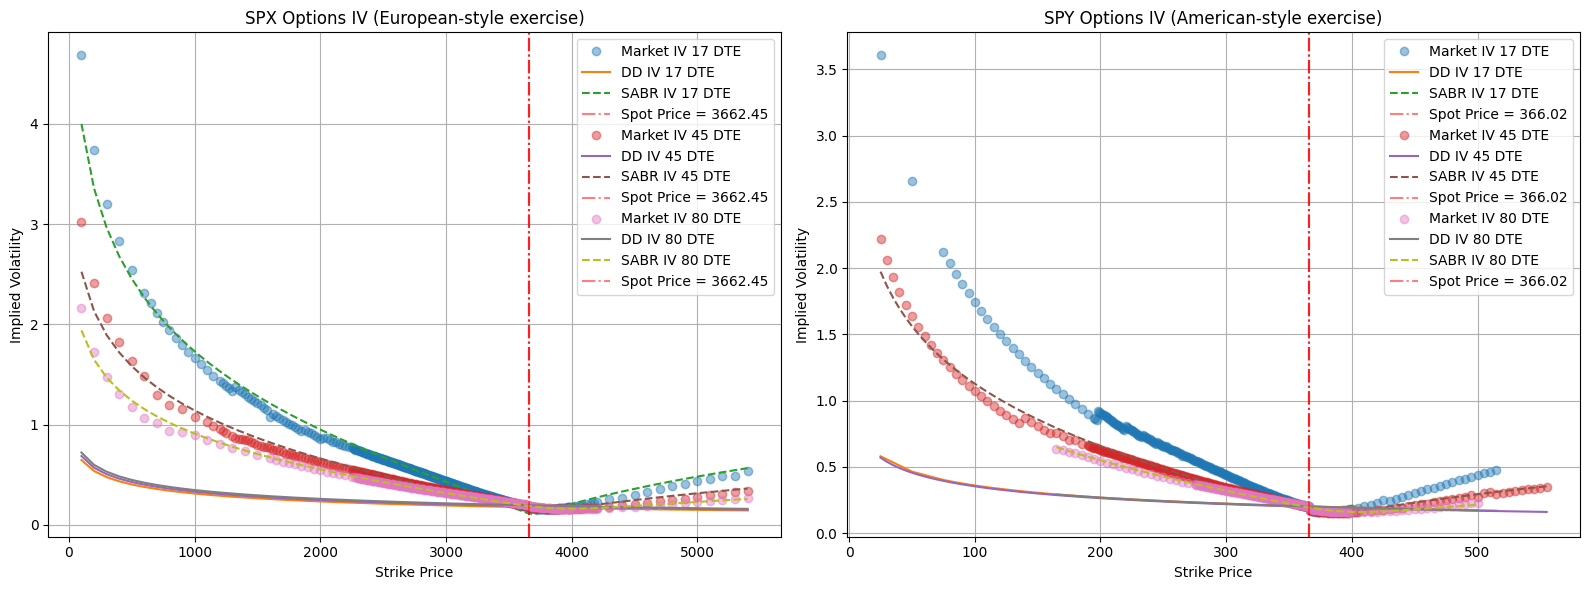

Displaced Diffusion Parameters:
{'17': {'sigma': 0.200905534391913, 'beta': 1.744587098400871e-06}, '45': {'sigma': 0.1972176434869465, 'beta': 1.0411537583235387e-06}, '80': {'sigma': 0.2002402677797878, 'beta': 4.014103476246119e-08}}

SABR Model Parameters:
{'17': {'F': 366.0413953221589, 'alpha': nan, 'beta': 0.7, 'rho': nan, 'nu': nan}, '45': {'F': 366.11256803322914, 'alpha': 0.9081326360302763, 'beta': 0.7, 'rho': -0.4887794494344319, 'nu': 2.7285163390137184}, '80': {'F': 366.1970384412155, 'alpha': 1.1209243544558904, 'beta': 0.7, 'rho': -0.6329391714869252, 'nu': 1.7422247726986908}}


In [ ]:

# Initialize data and pricer
spx_df = pd.read_csv("SPX_options.csv")
spy_df = pd.read_csv("SPY_options.csv")
rates_df = pd.read_csv("zero_rates_20201201.csv")
vanilla_option = PlainVanillaPricer()

# Process rates data
def prepare_rates(data):
    rates = data.copy()
    rates["date"] = pd.to_datetime(rates["date"], format="%Y%m%d")
    rates["rate_decimal"] = rates["rate"] / 100
    rates.set_index("days", inplace=True)
    full_days = np.arange(rates.index.min(), rates.index.max() + 1)
    rates = rates.reindex(full_days)
    rates["rate_decimal"] = rates["rate_decimal"].interpolate(method="linear")
    return rates

processed_rates = prepare_rates(rates_df)

# Process options data
def prepare_options(data):
    options = data.copy()
    options["date"] = pd.to_datetime(options["date"], format="%Y%m%d")
    options["exdate"] = pd.to_datetime(options["exdate"], format="%Y%m%d")
    options["days_to_expiry"] = (options["exdate"] - options["date"]).dt.days
    options["years_to_expiry"] = options["days_to_expiry"] / 365
    options["mid_price"] = 0.5 * (options["best_bid"] + options["best_offer"])
    options["strike_price"] = options["strike_price"] / 1000
    options["options_type"] = options["cp_flag"].map({"C": "call", "P": "put"})
    return options

processed_spx = prepare_options(spx_df)
processed_spy = prepare_options(spy_df)

# Set spot prices
spot_spx = 3662.45
spot_spy = 366.02

# Compute implied volatilities
def compute_implied_volatility(options_df, current_spot, rates):
    iv_dict = {}
    unique_dte = options_df["days_to_expiry"].unique()
    
    for dte in unique_dte:
        subset = options_df[options_df["days_to_expiry"] == dte].reset_index(drop=True)
        rate = rates.loc[int(dte), "rate_decimal"]
        subset["implied_vol"] = subset.apply(
            lambda row: vanilla_option.calculate_implied_volatility(
                current_spot,
                row["strike_price"],
                rate,
                row["mid_price"],
                row["years_to_expiry"],
                row["options_type"]
            ),
            axis=1
        )
        subset.dropna(inplace=True)
        
        calls = subset[subset["options_type"] == "call"]
        puts = subset[subset["options_type"] == "put"]
        strikes = puts["strike_price"].values
        implied_vols = []
        options_type = []
        
        for strike in strikes:
            if current_spot < strike:
                options_type.append("call")
                vol = calls[calls["strike_price"] == strike]["implied_vol"].values
            else:
                options_type.append("put")
                vol = puts[puts["strike_price"] == strike]["implied_vol"].values
            implied_vols.append(vol[0] if len(vol) > 0 else np.nan)
        
        iv_df = pd.DataFrame({
            "strike": strikes,
            "implied_vol": implied_vols,
            "options_type": options_type
        })
        iv_dict[str(int(dte))] = iv_df
    
    return iv_dict





In [ ]:
implied_vol_spx = compute_implied_volatility(processed_spx, spot_spx, processed_rates)
implied_vol_spy = compute_implied_volatility(processed_spy, spot_spy, processed_rates)


In [ ]:
## Calibrate DD parameters
dd_params_spx = vanilla_option.calibrate_DD_parameters(implied_vol_spx, spot_spx, processed_rates)
dd_params_spy = vanilla_option.calibrate_DD_parameters(implied_vol_spy, spot_spy, processed_rates)


In [21]:
dd_params_spx

{'17': {'sigma': 0.17448532472572187, 'beta': 1.4795063442918455e-07},
 '45': {'sigma': 0.1849096526276905, 'beta': 1.3170464196500995e-06},
 '80': {'sigma': 0.19374721854522414, 'beta': 4.86020840256893e-08}}

In [20]:
dd_params_spy

{'17': {'sigma': 0.200905534391913, 'beta': 1.744587098400871e-06},
 '45': {'sigma': 0.1972176434869465, 'beta': 1.0411537583235387e-06},
 '80': {'sigma': 0.2002402677797878, 'beta': 4.014103476246119e-08}}

In [ ]:
## Calibrate SABR parameters
fixed_beta = 0.7
sabr_params_spx = vanilla_option.calibrate_SABR_parameters(implied_vol_spx, spot_spx, processed_rates, fixed_beta)
sabr_params_spy = vanilla_option.calibrate_SABR_parameters(implied_vol_spy, spot_spy, processed_rates, fixed_beta)

In [ ]:
sabr_params_spx

In [22]:
sabr_params_spy

{'17': {'F': 366.0413953221589,
  'alpha': nan,
  'beta': 0.7,
  'rho': nan,
  'nu': nan},
 '45': {'F': 366.11256803322914,
  'alpha': 0.9081326360302763,
  'beta': 0.7,
  'rho': -0.4887794494344319,
  'nu': 2.7285163390137184},
 '80': {'F': 366.1970384412155,
  'alpha': 1.1209243544558904,
  'beta': 0.7,
  'rho': -0.6329391714869252,
  'nu': 1.7422247726986908}}

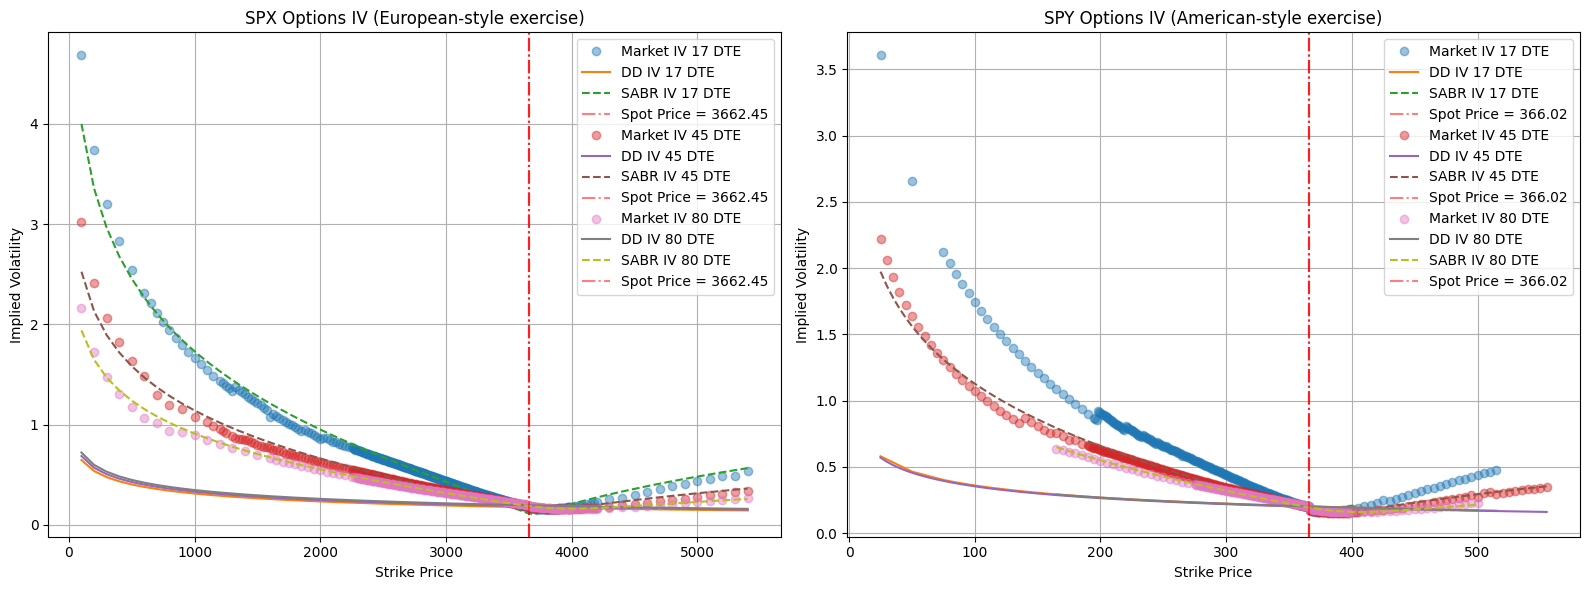

Displaced Diffusion Parameters:
{'17': {'sigma': 0.200905534391913, 'beta': 1.744587098400871e-06}, '45': {'sigma': 0.1972176434869465, 'beta': 1.0411537583235387e-06}, '80': {'sigma': 0.2002402677797878, 'beta': 4.014103476246119e-08}}

SABR Model Parameters:
{'17': {'F': 366.0413953221589, 'alpha': nan, 'beta': 0.7, 'rho': nan, 'nu': nan}, '45': {'F': 366.11256803322914, 'alpha': 0.9081326360302763, 'beta': 0.7, 'rho': -0.4887794494344319, 'nu': 2.7285163390137184}, '80': {'F': 366.1970384412155, 'alpha': 1.1209243544558904, 'beta': 0.7, 'rho': -0.6329391714869252, 'nu': 1.7422247726986908}}


In [23]:

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot SPX
vanilla_option.plot_volatilities(
    axes[0],
    implied_vol_spx,
    dd_params_spx,
    sabr_params_spx,
    spot_spx,
    processed_rates,
    "SPX Options IV (European-style exercise)"
)

# Plot SPY
vanilla_option.plot_volatilities(
    axes[1],
    implied_vol_spy,
    dd_params_spy,
    sabr_params_spy,
    spot_spy,
    processed_rates,
    "SPY Options IV (American-style exercise)"
)

plt.tight_layout()
plt.show()

dd_calibrated_params = {**dd_params_spx, **dd_params_spy}
sabr_calibrated_params = {**sabr_params_spx, **sabr_params_spy}

print("Displaced Diffusion Parameters:")
print(dd_calibrated_params)
print("\nSABR Model Parameters:")
print(sabr_calibrated_params)